<a href="https://colab.research.google.com/github/Mainakdeb/bank-me-later/blob/master/bank-me-later.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import seaborn as sn
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/My Drive/bank-full.csv')
df.head()

,"age;""job"";""marital"";""education"";""default"";""balance"";""housing"";""loan"";""contact"";""day"";""month"";""duration"";""campaign"";""pdays"";""previous"";""poutcome"";""y"""
0,"58;""management"";""married"";""tertiary"";""no"";2143..."
1,"44;""technician"";""single"";""secondary"";""no"";29;""..."
2,"33;""entrepreneur"";""married"";""secondary"";""no"";2..."
3,"47;""blue-collar"";""married"";""unknown"";""no"";1506..."
4,"33;""unknown"";""single"";""unknown"";""no"";1;""no"";""n..."


In [ ]:
split_data = df['age;"job";"marital";"education";"default";"balance";"housing";"loan";"contact";"day";"month";"duration";"campaign";"pdays";"previous";"poutcome";"y"'].str.split(";")

data = split_data.to_list()

names = ["Age", 
         "Job", 
         "Marital-status", 
         "Education", 
         "Default", 
         "Balance", 
         "Housing", 
         "Loan", 
         "Contact", 
         "Day", 
         "Month", 
         "Duration", 
         "Campaign", 
         "Prev-days", 
         "Prev-contacts", 
         "Prev-outcome", 
         "op"]

df2 = pd.DataFrame(data, columns=names)
df2.head()

,Age,Job,Marital-status,Education,Default,Balance,Housing,Loan,Contact,Day,Month,Duration,Campaign,Prev-days,Prev-contacts,Prev-outcome,op
0,58,"""management""","""married""","""tertiary""","""no""",2143,"""yes""","""no""","""unknown""",5,"""may""",261,1,-1,0,"""unknown""","""no"""
1,44,"""technician""","""single""","""secondary""","""no""",29,"""yes""","""no""","""unknown""",5,"""may""",151,1,-1,0,"""unknown""","""no"""
2,33,"""entrepreneur""","""married""","""secondary""","""no""",2,"""yes""","""yes""","""unknown""",5,"""may""",76,1,-1,0,"""unknown""","""no"""
3,47,"""blue-collar""","""married""","""unknown""","""no""",1506,"""yes""","""no""","""unknown""",5,"""may""",92,1,-1,0,"""unknown""","""no"""
4,33,"""unknown""","""single""","""unknown""","""no""",1,"""no""","""no""","""unknown""",5,"""may""",198,1,-1,0,"""unknown""","""no"""


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             45211 non-null  object
 1   Job             45211 non-null  object
 2   Marital-status  45211 non-null  object
 3   Education       45211 non-null  object
 4   Default         45211 non-null  object
 5   Balance         45211 non-null  object
 6   Housing         45211 non-null  object
 7   Loan            45211 non-null  object
 8   Contact         45211 non-null  object
 9   Day             45211 non-null  object
 10  Month           45211 non-null  object
 11  Duration        45211 non-null  object
 12  Campaign        45211 non-null  object
 13  Prev-days       45211 non-null  object
 14  Prev-contacts   45211 non-null  object
 15  Prev-outcome    45211 non-null  object
 16  op              45211 non-null  object
dtypes: object(17)
memory usage: 5.9+ MB


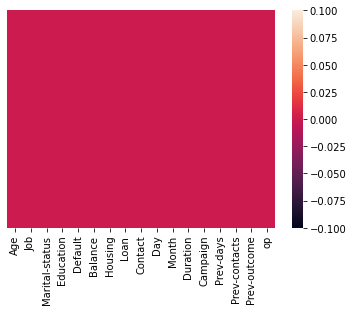

In [ ]:
sn.heatmap(df2.isnull(), yticklabels=False)
df2.info()

In [ ]:
def convert_categorical(category, df):
    s = str(category)
    df = pd.get_dummies(df, columns=[s])
    return df

def encode_df(df):
    
    df_encoded = convert_categorical('Job', df)
    df_encoded = convert_categorical('Marital-status', df_encoded)
    df_encoded = convert_categorical('Education', df_encoded)
    df_encoded = convert_categorical('Default', df_encoded)
    df_encoded = convert_categorical('Housing', df_encoded)
    df_encoded = convert_categorical('Loan', df_encoded)
    df_encoded = convert_categorical('Contact', df_encoded)
    df_encoded = convert_categorical('Month', df_encoded)
    df_encoded1 = convert_categorical('Prev-outcome', df_encoded)
  
    return(df_encoded1)


df_encoded = encode_df(df2)
df_encoded.head()


,Age,Balance,Day,Duration,Campaign,Prev-days,Prev-contacts,op,"Job_""admin.""","Job_""blue-collar""","Job_""entrepreneur""","Job_""housemaid""","Job_""management""","Job_""retired""","Job_""self-employed""","Job_""services""","Job_""student""","Job_""technician""","Job_""unemployed""","Job_""unknown""","Marital-status_""divorced""","Marital-status_""married""","Marital-status_""single""","Education_""primary""","Education_""secondary""","Education_""tertiary""","Education_""unknown""","Default_""no""","Default_""yes""","Housing_""no""","Housing_""yes""","Loan_""no""","Loan_""yes""","Contact_""cellular""","Contact_""telephone""","Contact_""unknown""","Month_""apr""","Month_""aug""","Month_""dec""","Month_""feb""","Month_""jan""","Month_""jul""","Month_""jun""","Month_""mar""","Month_""may""","Month_""nov""","Month_""oct""","Month_""sep""","Prev-outcome_""failure""","Prev-outcome_""other""","Prev-outcome_""success""","Prev-outcome_""unknown"""
0,58,2143,5,261,1,-1,0,"""no""",0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,44,29,5,151,1,-1,0,"""no""",0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,33,2,5,76,1,-1,0,"""no""",0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,47,1506,5,92,1,-1,0,"""no""",0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,33,1,5,198,1,-1,0,"""no""",0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
